In [554]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [553]:
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import spiceypy as spice
import scipy.sparse.linalg

from flux.form_factors import get_form_factor_block
from flux.nmf import NmfBuilder
from flux.quadtree import get_quadrant_order
from flux.shape import TrimeshShapeModel

from scipy.optimize import lsq_linear

from sklearn.decomposition import NMF

In [21]:
clktol = '10:000'

spice.kclear()
spice.furnsh('simple.furnsh')

# Define time window

et0 = spice.str2et('2011 MAR 01 00:00:00.00')
et1 = spice.str2et('2011 APR 01 00:00:00.00')
et = np.linspace(et0, et1, 100, endpoint=False)

# Sun positions over time period

possun = spice.spkpos('SUN', et, 'MOON_ME', 'LT+S', 'MOON')[0]
lonsun = np.arctan2(possun[:, 1], possun[:, 0])
lonsun = np.mod(lonsun, 2*np.pi)
radsun = np.sqrt(np.sum(possun[:, :2]**2, axis=1))
latsun = np.arctan2(possun[:, 2], radsun)

sun_dirs = np.array([
    np.cos(lonsun)*np.cos(latsun),
    np.sin(lonsun)*np.cos(latsun),
    np.sin(latsun)
]).T

# Use these temporary parameters...

F0 = 1365 # Solar constant

In [4]:
V = np.load('lsp_V.npy')
F = np.load('lsp_F.npy')
N = np.load('lsp_N.npy')
shape_model = TrimeshShapeModel(V, F, N)
FF_gt = get_form_factor_block(shape_model)

In [25]:
E = shape_model.get_direct_irradiance(F0, sun_dirs)
e = E[:, 0]

In [10]:
P = V[F].mean(1)
I = get_quadrant_order(P[:, :2])

In [11]:
inds1, inds2 = I[0], I[2]

In [28]:
block_gt = FF_gt[inds2, :][:, inds1]

In [22]:
nmf = NMF(n_components=5, init='nndsvd', max_iter=1000)
W = nmf.fit_transform(FF_gt[inds2, :][:, inds1])
H = nmf.components_; W = scipy.sparse.csc_matrix(W)
H = scipy.sparse.csr_matrix(H)

In [41]:
thresh_perc = 5e-3

In [42]:
res = (block_gt - W@H).toarray(); res_trunc = res.copy()
res_trunc[abs(res_trunc) < thresh_perc*abs(res).max()] = 0
print((res_trunc != 0).sum())
res_trunc = scipy.sparse.csr_matrix(res_trunc)

35567


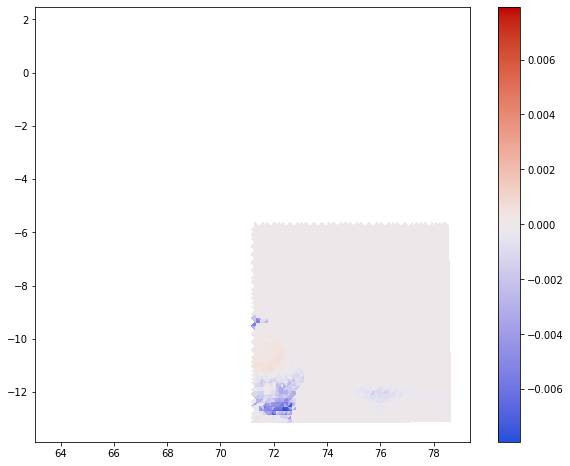

In [43]:
tmp = W@(H@(e[inds1])) + res_trunc@e[inds1] - block_gt@e[inds1]
plt.figure(figsize=(10, 8))
plt.tripcolor(*V[:,:2].T, F[inds2], tmp, cmap=cc.cm.coolwarm, vmin=-abs(tmp).max(), vmax=abs(tmp).max())
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

Okay, let's try to compute the NMF _on our own_...

In [47]:
k = 5
m, n = block_gt.shape

In [198]:
class MatMulOperator(scipy.sparse.linalg.LinearOperator):

    def __init__(self, A, p):
        self.A = A
        self.p = p

    @property
    def m(self):
        return self.A.shape[0]
    
    @property
    def n(self):
        return self.A.shape[1]

    @property
    def shape(self):
        return (self.m*self.p, self.p*self.n)
    
    @property
    def dtype(self):
        return self.A.dtype

    def _matvec(self, b):
        print('_matvec')
        return (self.A@b.reshape(self.n, self.p)).ravel()
    
    def _rmatvec(self, b):
        print('_rmatvec')
        return (self.A.T@b.reshape(self.m, b.size//self.m)).T.ravel()

$f(w, h) = \frac{1}{2}\|A - w h^\top\|^2, \quad w \geq 0, \quad h \geq 0$

$f_w = (A - w h^\top) h = A h - \|h\|^2 w$

$f_h = (A - w h^\top)^\top w = A^\top w - \|w\|^2 h$

$w^+ \gets w + \alpha f_w, \quad 0 \leq f(w + \alpha f_w, h) = \frac{1}{2}\|A - (w + \alpha f_w) h^\top\|^2$

$w^+ = w + \alpha f_w = w + \alpha (A h - \|h\|^2 w)$

$\alpha = \mbox{arg}\max_{\alpha \geq 0} \left\{w_i + \alpha (A h - \|h\|^2 w)_i \geq 0, i = 1, ..., m\right\}$

In [395]:
A = block_gt.toarray()
m, n = A.shape
mean = np.mean(A)
w = np.ones(m)
h = np.ones(n)
print(norm, np.linalg.norm(np.outer(w, h)))

0.007475402537405055 4900.499974492399


In [396]:
R = A - np.outer(w, h)
print(np.linalg.norm(R, 'fro'))

4900.49987793182


In [401]:
Ap = R + np.outer(w, h)
h = np.maximum(0, Ap.T@w)
w = np.maximum(0, Ap@h)
w /= np.linalg.norm(w)
R = Ap - np.outer(w, h)
print((w != 0).sum(), (h != 0).sum())
print(np.linalg.norm(R, 'fro'))

3350 871
0.0045065503328216


In [406]:
(A != 0).sum()

344734

In [559]:
nmf_builder = NmfBuilder(A)

In [564]:
nmf_builder.solve(tol=1e-4)

0.9999201181020699
0.003698092355103473
0.0029821274512413128


In [563]:
nmf_builder.add_term()

In [508]:
i0, j0, bsize = 700, 2600, 512

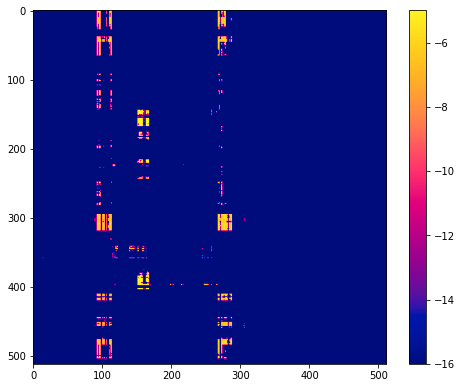

In [521]:
plt.figure(figsize=(8, 6.5))
plt.imshow(np.log10(np.maximum(1e-16, A[i0:i0+bsize, j0:j0+bsize])), 
           cmap=cc.cm.bmy, vmin=-16, vmax=-5)
plt.colorbar()

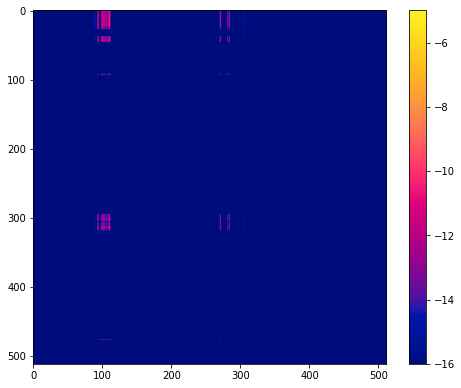

In [565]:
plt.figure(figsize=(8, 6.5))
plt.imshow(np.log10(np.maximum(1e-16, np.outer(nmf_builder.W, nmf_builder.H)[i0:i0+bsize, j0:j0+bsize])), 
           vmin=-16, vmax=-5, cmap=cc.cm.bmy)
plt.colorbar()